In [23]:
import glob
import h5py 
import librosa
from librosa import cqt
from librosa.core import amplitude_to_db
from librosa.display import specshow
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
from scipy.spatial import ConvexHull
from sklearn.model_selection import ParameterGrid
from sklearn.manifold import Isomap
import time
from tqdm import tqdm


In [24]:
hop_size = 512
q = 24

setting = {
    'Q': 24,
    'k': 3,
    'comp': 'log',
    'instr': '', # Replace by 'Tp' for trumpet or 'Hp' for harp
}

with h5py.File("TinySOL.h5", "r") as f:
    features_dict = {
        key:f[key][()]
        for key in f.keys()
        if setting["instr"] in key
    }

In [25]:
CQT_OCTAVES = 7
features_keys = list(features_dict.keys())

q = setting['Q']
# Batch process and store in a folder
batch_str = [setting['instr']]

batch_features = []
for feature_key in features_keys:
    # Get features that match setting

    if all(x in feature_key for x in batch_str):
        batch_features.append(features_dict[feature_key])

batch_features = np.stack(batch_features, axis=1)

# Isomap parameters
hop_size = 512
compression = 'log'
features = amplitude_to_db(batch_features)
n_neighbors = setting['k']
n_dimensions = 3
n_octaves = 3    

# Prune feature matrix
bin_low = np.where((np.std(features, axis=1) / np.std(features)) > 0.1)[0][0] + q
bin_high = bin_low + n_octaves*q 
X = features[bin_low:bin_high, :]

# Z-score Standardization- improves contrast in correlation matrix
mus = np.mean(X, axis=1)
sigmas = np.std(X, axis=1)
X_std = (X - mus[:, np.newaxis]) / (1e-6 + sigmas[:, np.newaxis]) # 1e-6 to avoid runtime division by zero

# Pearson correlation matrix
rho_std = np.dot(X_std, X_std.T) / X_std.shape[1]

# Isomap embedding
isomap = Isomap(n_components= n_dimensions, n_neighbors= n_neighbors)
coords = isomap.fit_transform(rho_std)

# Convex hull
xy_coords = coords[:, :2]
hull = ConvexHull(xy_coords)
hull_vertices = xy_coords[hull.vertices, :]

# Center of gravity
hull_center = np.mean(hull_vertices, axis=0)

In [26]:
n_iterations = 500

# Initialize
center = np.copy(hull_center)

centers = []
losses = []

for iteration in range(n_iterations):
    # Compute gradient
    # Equation 5 from Coope 1992. 
    # "Circle fitting by linear and nonlinear least squares".
    xy_vectors = center - xy_coords
    radius = np.mean(np.linalg.norm(xy_vectors, axis=1))
    azimuths = xy_vectors / np.linalg.norm(xy_vectors, axis=1)[:, np.newaxis]
    gradient = 2 * (np.mean(xy_vectors, axis=0) - radius * np.mean(azimuths, axis=0))

    # Compute candidate directions
    directions = hull_vertices - center
    inner_products = np.dot(directions, gradient)
    best_direction = directions[np.argmin(inner_products)]

    # Gradient descent update
    learning_rate = 0.01 * 2*iteration/(2+iteration)
    center += learning_rate * best_direction
    
    # Compute loss
    loss = np.linalg.norm(xy_vectors)**2 - np.sum(np.linalg.norm(xy_vectors, axis=1))**2 / xy_vectors.shape[0]
    losses.append(loss)
    centers.append(np.copy(center))
    
centers = np.array(centers)

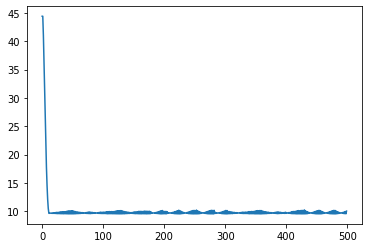

In [27]:
plt.plot(losses)

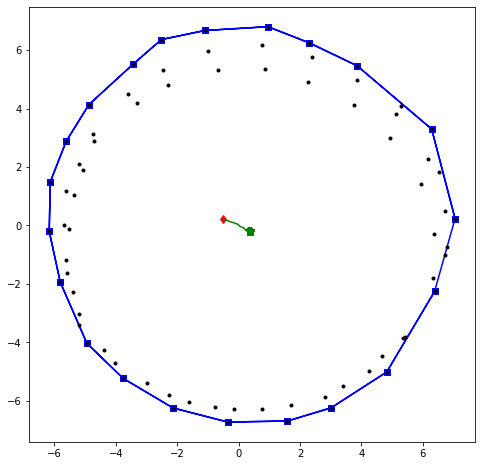

In [28]:
plt.figure(figsize=(8, 8))
plt.plot(
    np.concatenate([hull_vertices[:, 0], hull_vertices[0:, 0]]),
    np.concatenate([hull_vertices[:, 1], hull_vertices[0:, 1]]),
    '-s', color='b')
plt.plot(hull_center[np.newaxis, 0], hull_center[np.newaxis, 1], 'd', color='r')
plt.plot(centers[:, 0], centers[:, 1], '-', color='g')
plt.plot(centers[-1:, 0], centers[-1:, 1], 's', color='g')
plt.plot(xy_coords[:, 0], xy_coords[:, 1], '.', color='k', alpha=1.0)

